<a href="https://colab.research.google.com/github/GwPlNicker/analyst/blob/main/skf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Анализ данных по госпитализации больных за 10 лет

# Описание данных
Каждый пациент описывается следующим набором признаков:
- `Возраст`, `Среднемесячный расход`, `Средняя продолжительность разговоров`, `Звонков днем за месяц`, `Звонков вечером за месяц`, `Звонков ночью за месяц`, `Звонки в другие города`, `Звонки в другие страны`, `Доля звонков на стационарные телефоны`, `Количество SMS за месяц`, `Дата подключения тарифа`, `Социальная категория`.

## Примерный план по выполнению проекта:
1. Загрузка данных
2. Отсев данных, не несущих информацию
3.
4.
5.
6.
7.


---
# Загружаем данные и импортируем используемые библиотеки

In [13]:
# Подключаем библиотеки пандас, нампи и работы с графиками
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Отключаем предупреждения
import warnings
from ipywidgets.widgets.widget_color import Color
warnings.filterwarnings("ignore")

# тесты для проверки гипотез о законе распределения
from scipy.stats import shapiro
from scipy.stats import kstest
from scipy.stats import ks_2samp
from scipy.stats import anderson
from scipy.stats import jarque_bera

# тесты для проверки гипотезы о равенстве параметров распределений
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from scipy.stats import kruskal

# работа с датой
import datetime as dt

# Подключаем гугл-диск
#from google.colab import drive
#drive.mount('/content/drive')

# загружаем датафрейм
df = pd.read_csv('/content/data_skf.csv', delimiter = ';' )
df_dgn = pd.read_csv('/content/data_dgn.csv', delimiter = ';')

# Удалим лишние временные данные
df.drop(columns=['KlKr','KlKrStd'], inplace=True)

# Просматриваем информацию о данных

In [15]:
# объявляем словарь для использования в качестве удобочитаемых заголовков
colren = {
  'Kreatinin': 'Уровень креатинина',
  'SKF': 'СКФ',
  'Pol': 'Пол',
  'Region': 'Код субьекта РФ',
  'Dt_Cons': 'Дата консультации',
  'Motconsu': 'Номер записи',
  'BoD': 'Дата рождения',
  'Selo': 'Признак села'
 }

In [ ]:
print(df.info())
print(df.columns)
df.columns.rename(colren, inplace=True)
df.head(5)

# Проверяем на пустые значения

In [ ]:
# Проверка на пустые значения
df.isna().sum()

DATA123_ID                        0
PATIENTS_ID                       0
DATE_CONSULTATION                 0
MOTCONSU_ID                       0
NAPR_V_OTDELENIE              15214
VID_STACIONARA                   35
NOMER_ISTORII_BOLEZNI            37
RESULT                            0
DATA_I_VREMQ_POSTUPLENIQ          8
OTDELENIE                     15139
KANAL_GOSPITALIZACII            114
VID_OPLAT                        22
KEM_NAPRAVLEN_BOL_NOJ          2531
KEM_DOSTAVLEN                   238
NOMER_NAPRAVLENIQ             21849
DATA_NAPRAVLENIQ              78372
GOSPITALIZACIQ_V_DANNOM_G       351
DOSTAVLEN_V_STACIONAR            93
TRAVMA                       122651
RODN_M_SOOBHILI                   0
OTKAZAT_V_GOSPITALIZACII        778
OTKAZ_V_PRIEME               107568
PRIHINA_OTKAZA               107590
DATA_I_VREMQ_OTKAZA          107593
NOMER_OTKAZA                 107611
PRINQT_E_MER                 107600
POLE_VIDIMOSTI                   38
PRICHINA_POVTORNOY_GOSPIT   

# Смотрим соответствие типов столбцов

#  Приводим типы столбцов к необходимым

In [ ]:
#print(df.head(10))
col_int = ['VID_STACIONARA',
        'OTDELENIE',
        'ADM_MEDDEP_ID',
        'VRACH_OTKAZAVSHIY_V_GOSPI',
        'RESULT',
        'NOMER_ISTORII_BOLEZNI',
        #'KANAL_GOSPITALIZACII',
        'VID_OPLAT',
        'NAPRAVLENIE_VYDANO',
        'PO_NEOTLOZHNYM_POKAZANIYA',
        'NUZHDAETSYA_V_SOPROVOZHDA',
        'GOSP_TYPE',
        'MR',
        'MRT_S_ANESTEZIEY',
        'KANAL_GOSPITALIZACII',
        'GOSPITALIZACIQ_V_DANNOM_G',
        'TRAVMA',
        'POL'] #,'NAPR_V_OTDELENIE','NOMER_TALONA_NA_VMP'
col_dat = ['DATE_CONSULTATION', 'DATA_I_VREMQ_POSTUPLENIQ','DATA_NAPRAVLENIQ','NE_LE']
cat_var = ['VID_STACIONARA',
        'OTDELENIE',
        'ADM_MEDDEP_ID',
        'VRACH_OTKAZAVSHIY_V_GOSPI',
        'KANAL_GOSPITALIZACII',
        'VID_OPLAT',
        'NAPRAVLENIE_VYDANO',
        'PO_NEOTLOZHNYM_POKAZANIYA',
        'NUZHDAETSYA_V_SOPROVOZHDA',
        'GOSP_TYPE',
        'MR',
        'MRT_S_ANESTEZIEY',
        'GOSPITALIZACIQ_V_DANNOM_G',
        'TRAVMA',
        'YearIn',
        'POL',
        'AgeIn',]
for col in col_int:
  print(col, df[col].unique())
  print(col, df[col].mode()[0])

#df[cols] = df[cols].fillna(0)
#df[cols].dtypes

VID_STACIONARA [ 1.  3. nan  2.]
VID_STACIONARA 1.0
OTDELENIE [33.  4.  5. nan  6. 19. 21. 31.  7. 27. 25. 28. 26. 11. 47.]
OTDELENIE 5.0
ADM_MEDDEP_ID [ 861.   nan 1226.  886. 1240. 2140.  432.  549. 1857.  941.  642. 1401.
 1030.  984. 1717.  273. 1031.  420.  936.  560.  393.  391. 1778. 1124.
 1664.  745.  644. 1152.  579. 1201. 1033.  940. 1718. 1937. 1154. 1627.
 1211.  643. 1024. 1209. 1120.  337. 1249. 1139.  930. 1104.  620. 1035.
 1118.  442.  985.  747.  446.  665.  719.]
ADM_MEDDEP_ID 861.0
VRACH_OTKAZAVSHIY_V_GOSPI [  nan 1553.  521.  103.  341.  403.  547.  195.  374.  353. 1552. 1575.
   39. 1601. 1715.  248.  144. 1585. 1573.  355. 1586.  319.  233. 1614.
   88.  347.   18.  357.  390.  279.  322. 1607.  231. 1581. 1613. 1623.
  297.   89.  298. 1632.  203.  207.  240. 1559. 1540.]
VRACH_OTKAZAVSHIY_V_GOSPI 1553.0
RESULT [0]
RESULT 0
NOMER_ISTORII_BOLEZNI [6544. 6255. 6542. ... 6559. 6562. 6561.]
NOMER_ISTORII_BOLEZNI 1.0
VID_OPLAT [ 0.  7.  2.  1.  4.  3.  6. nan  5.]


In [ ]:
df[col_dat] = df[col_dat].astype('datetime64[ns]')
df[col_int] = df[col_int].fillna(0).astype (int)
df['NAPR_V_OTDELENIE'].fillna('').astype ('string')
# Добавляем колонку года госпитализации
df['YearIn'] = df['DATE_CONSULTATION'].dt.year
# Добавляем колонку возвраста на момент госпитализации
df['AgeIn'] = (df['DATE_CONSULTATION'] - df['NE_LE']) / np.timedelta64 ( 1 , 'Y')
df.dtypes

DATA123_ID                            int64
PATIENTS_ID                           int64
DATE_CONSULTATION            datetime64[ns]
MOTCONSU_ID                           int64
NAPR_V_OTDELENIE                     object
VID_STACIONARA                        int64
NOMER_ISTORII_BOLEZNI                 int64
RESULT                                int64
DATA_I_VREMQ_POSTUPLENIQ     datetime64[ns]
OTDELENIE                             int64
KANAL_GOSPITALIZACII                  int64
VID_OPLAT                             int64
KEM_NAPRAVLEN_BOL_NOJ                object
KEM_DOSTAVLEN                        object
NOMER_NAPRAVLENIQ                    object
DATA_NAPRAVLENIQ             datetime64[ns]
GOSPITALIZACIQ_V_DANNOM_G             int64
DOSTAVLEN_V_STACIONAR                object
TRAVMA                                int64
RODN_M_SOOBHILI                       int64
OTKAZAT_V_GOSPITALIZACII            float64
OTKAZ_V_PRIEME                      float64
PRIHINA_OTKAZA                  

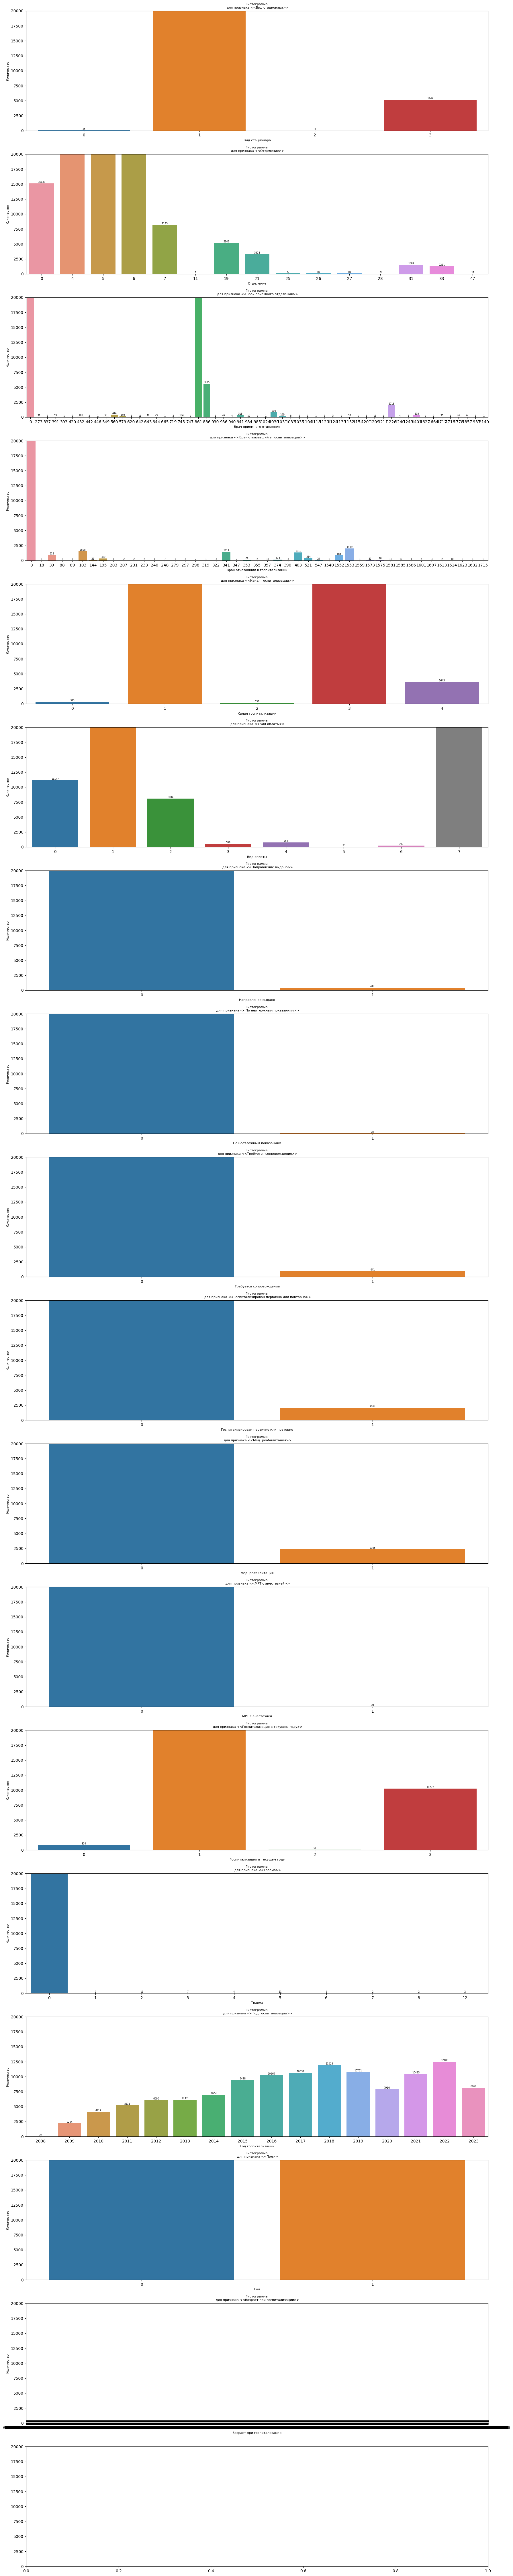

In [ ]:
# 1й вариант
fig, axes = plt.subplots(18, 1, sharey=True, figsize=(18,90))
i=0
for i, col in enumerate(cat_var):
    plt.subplot(18,1,i+1)
    ax = sns.countplot(x=col, data=df,)
    plt.title("Гистограмма \n для признака <<{}>>".format(colren[col]), fontsize = 8)
    plt.xlabel(colren[col], fontsize = 8)
    plt.ylabel('Количество', fontsize = 8)
    plt.ylim(top=20000)
    plt.tight_layout()
    for pts in ax.patches:
        x=pts.get_bbox().get_points()[:,0]
        y=pts.get_bbox().get_points()[1,1]
        ax.annotate('{:.0f}'.format(pts.get_height()), (x.mean(), y), ha = 'center', va = 'bottom', fontsize = 6)


   DayCallInMon  EveningCallInMon
1         111.0             109.0
2          41.0              27.0
3          47.0              49.0
4          58.0              77.0
5          45.0              75.0
        DayCallInMon  EveningCallInMon
min         1.000000          1.000000
mean       63.907223         70.293905
median     53.000000         71.000000
max       500.000000        160.000000
   DayCallInMon  EveningCallInMon
0          53.0               3.0


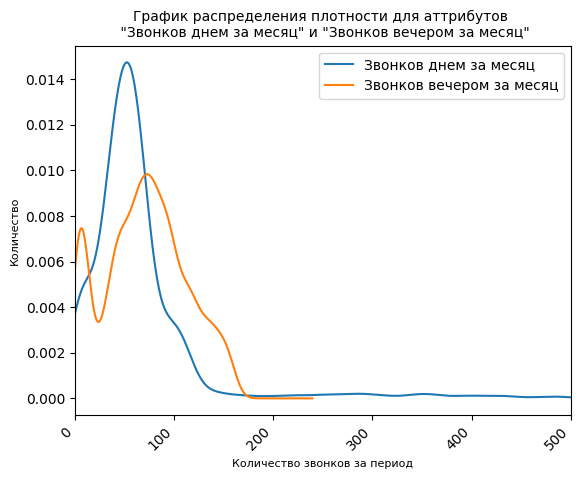

In [ ]:
# Сформулировать и проверить следующие гипотезы
#   клиенты чаще звонят днем или вечером по количеству звонков;
#   клиенты чаще звонят днем или (вечером + ночью) по количеству звонков;
#   студенты звонят чаще аспирантов ко количеству звонков;
#   клиенты больше звонили в 2019 году по сравнению с 2021 годом по количеству звонков;
#   студенты больше совершили звонков в 2019 году по сравнению с 2021 годом.
# Последовательность проверки:
#   Важно понять с какими данными мы работаем: выделяем исследуемые выборки;
#   Рассчитать точечные оценки (выборочное среднее, медиана, мода) и нарисовать графики плотности (если возможно);
#   Проверяем гипотезу о нормальности каждой из выборок.
#   Если обе выборки имеют нормальное распределение, то для проверки гипотезы о значимости их параметров необходимо применять критерий Стьюдента. В противном случае, т.е. хотя бы одна выборке не подчиняется нормальному закону, используем критерий Манна-Уитни.

# Выделим сборку
print(df[['DayCallInMon','EveningCallInMon']].head(5))
# Найдем основные функции
print( df[['DayCallInMon','EveningCallInMon']].agg(['min', pd.DataFrame.mean, pd.DataFrame.median, '':'max' ]) )
print( df[['DayCallInMon','EveningCallInMon']].mode() )


ax = df[['DayCallInMon','EveningCallInMon']].plot(kind = 'density')
plt.title('График распределения плотности для аттрибутов \n "Звонков днем за месяц" и "Звонков вечером за месяц"', fontsize = 10)
plt.xlabel('Количество звонков за период', fontsize = 8)
plt.ylabel('Количество', fontsize = 8)
plt.xticks(rotation = 45,  ha= 'right')
plt.xlim(0,500)
plt.legend(['Звонков днем за месяц', 'Звонков вечером за месяц'])



In [ ]:
# H0 - имеет нормальное распределение
# H1 - не имеет нормальное распределение
# Проверяем на нормальность с помощью критерия Шапиро
print('''
Проверка на нормальность Шапиро для "Звонков днем за месяц"\n
{}'''.format(shapiro(df['DayCallInMon'])))
print('''
Проверка на нормальность Шапиро для "Звонков вечером за месяц"\n
{}'''.format(shapiro(df['EveningCallInMon'])))
print(' pvalue < 0.05 - Распределение не соответствует нормальности')

# Проверяем на нормальность с помощью критерия Колмогорова-Смирнова
print('''
Проверка на нормальность Колмогорова-Смирнова для "Звонков днем за месяц"\n
{}'''.format( kstest(df['DayCallInMon'], 'norm', args=(df['DayCallInMon'].mean(), df['DayCallInMon'].std())) ))
print('''
Проверка на нормальность Колмогорова-Смирнова для "Звонков вечером за месяц"\n
{}'''.format( kstest(df['EveningCallInMon'], 'norm', args=(df['EveningCallInMon'].mean(), df['EveningCallInMon'].std())) ))
print(' pvalue < 0.05 - Распределение не соответствует нормальности')


# H0 : звонки днем и вечером статистически не отличаются
# H1 : звонки днем < звонков вечером, исходя из средних значений.
print('''
Тест Манна-Уитни\n
{}'''.format(mannwhitneyu(df.DayCallInMon, df.EveningCallInMon, alternative = 'less')))
print(' pvalue < 0.05 - верна гипотеза H1: вечером звонят чаще')
# Выводы в конце работы


Проверка на нормальность Шапиро для "Звонков днем за месяц"
 
ShapiroResult(statistic=0.6097855567932129, pvalue=0.0)

Проверка на нормальность Шапиро для "Звонков вечером за месяц"
 
ShapiroResult(statistic=0.9722208976745605, pvalue=1.6634125725695095e-28)
 pvalue < 0.05 - Распределение не соответствует нормальности

Проверка на нормальность Колмогорова-Смирнова для "Звонков днем за месяц"
 
KstestResult(statistic=0.24841148482932585, pvalue=2.678340502735771e-241, statistic_location=71.0, statistic_sign=1)

Проверка на нормальность Колмогорова-Смирнова для "Звонков вечером за месяц"
 
KstestResult(statistic=0.06669961597732588, pvalue=1.4032270686453868e-17, statistic_location=13.0, statistic_sign=1)
 pvalue < 0.05 - Распределение не соответствует нормальности

Тест Манна-Уитни
 
MannwhitneyuResult(statistic=7617513.0, pvalue=1.377833668305823e-74)
 pvalue < 0.05 - верна гипотеза H1: вечером звонят чаще


   DayCallInMon  EvNiCallInMon
1         111.0          110.0
2          41.0           27.0
3          47.0           49.0
4          58.0           81.0
5          45.0           78.0
        DayCallInMon  EvNiCallInMon
min         1.000000       1.000000
mean       63.907223      76.555305
median     53.000000      75.000000
max       500.000000     248.000000
   DayCallInMon  EvNiCallInMon
0          53.0            3.0


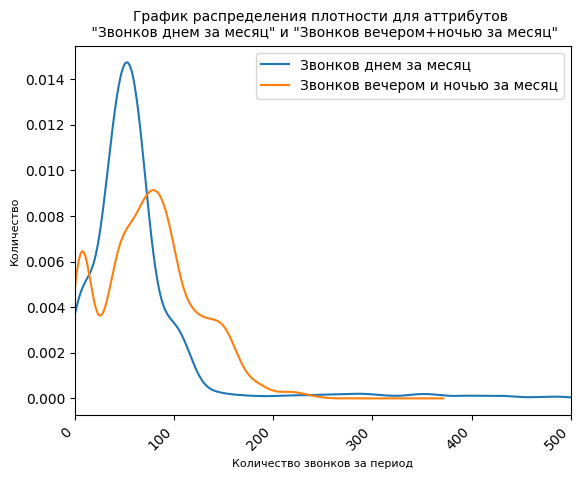

In [ ]:
# Сформулировать и проверить следующие гипотезы
#   клиенты чаще звонят днем или (вечером + ночью) по количеству звонков;
# Последовательность проверки:
#   Важно понять с какими данными мы работаем: выделяем исследуемые выборки;
#   Рассчитать точечные оценки (выборочное среднее, медиана, мода) и нарисовать графики плотности (если возможно);
#   Проверяем гипотезу о нормальности каждой из выборок.
#   Если обе выборки имеют нормальное распределение, то для проверки гипотезы о значимости их параметров необходимо применять критерий Стьюдента. В противном случае, т.е. хотя бы одна выборке не подчиняется нормальному закону, используем критерий Манна-Уитни.

# Выделим сборку
print(df[['DayCallInMon','EvNiCallInMon']].head(5))
# Найдем основные функции
print( df[['DayCallInMon','EvNiCallInMon']].agg(['min', pd.DataFrame.mean, pd.DataFrame.median, 'max' ]) )
print( df[['DayCallInMon','EvNiCallInMon']].mode() )


ax = df[['DayCallInMon','EvNiCallInMon']].plot(kind = 'density')
plt.title('График распределения плотности для аттрибутов \n "Звонков днем за месяц" и "Звонков вечером+ночью за месяц"', fontsize = 10)
plt.xlabel('Количество звонков за период', fontsize = 8)
plt.ylabel('Количество', fontsize = 8)
plt.xticks(rotation = 45,  ha= 'right')
plt.xlim(0,500)
plt.legend(['Звонков днем за месяц', 'Звонков вечером и ночью за месяц'])


In [ ]:
# среднее и медиана у ночных звонков больше чем у дневных
# H0 - имеет нормальное распределение
# H1 - не имеет нормальное распределение
# Проверяем на нормальность с помощью критерия Шапиро
print('''
Проверка на нормальность Шапиро для "Звонков днем за месяц"\n
{}'''.format(shapiro(df['DayCallInMon'])))
print('''
Проверка на нормальность Шапиро для "Звонков вечером+ночью за месяц"\n
{}'''.format(shapiro(df['EvNiCallInMon'])))
print(' pvalue < 0.05 - Распределение не соответствует нормальности')

# Проверяем на нормальность с помощью критерия Колмогорова-Смирнова
print('''
Проверка на нормальность Колмогорова-Смирнова для "Звонков днем за месяц"\n
{}'''.format( kstest(df['DayCallInMon'], 'norm', args=(df['DayCallInMon'].mean(), df['DayCallInMon'].std())) ))
print('''
Проверка на нормальность Колмогорова-Смирнова для "Звонков вечером+ночью за месяц"\n
{}'''.format( kstest(df['EvNiCallInMon'], 'norm', args=(df['EvNiCallInMon'].mean(), df['EvNiCallInMon'].std())) ))
print(' pvalue < 0.05 - Распределение не соответствует нормальности')


# H0 : звонки днем и вечером статистически не отличаются
# H1 : звонки днем < звонков вечером, исходя из средних значений.
print('''
Тест Манна-Уитни\n
{}'''.format(mannwhitneyu(df.DayCallInMon, df.EvNiCallInMon, alternative = 'less')))
print(' pvalue < 0.05 - верна гипотеза H1: вечером+ночью звонят чаще')
# Выводы в конце работы



Проверка на нормальность Шапиро для "Звонков днем за месяц"
 
ShapiroResult(statistic=0.6097855567932129, pvalue=0.0)

Проверка на нормальность Шапиро для "Звонков вечером+ночью за месяц"
 
ShapiroResult(statistic=0.9719788432121277, pvalue=1.2928023826230495e-28)
 pvalue < 0.05 - Распределение не соответствует нормальности

Проверка на нормальность Колмогорова-Смирнова для "Звонков днем за месяц"
 
KstestResult(statistic=0.24841148482932585, pvalue=2.678340502735771e-241, statistic_location=71.0, statistic_sign=1)

Проверка на нормальность Колмогорова-Смирнова для "Звонков вечером+ночью за месяц"
 
KstestResult(statistic=0.05597052354314929, pvalue=1.6705295146534765e-12, statistic_location=1.0, statistic_sign=-1)
 pvalue < 0.05 - Распределение не соответствует нормальности

Тест Манна-Уитни
 
MannwhitneyuResult(statistic=7216206.5, pvalue=1.79206243693732e-103)
 pvalue < 0.05 - верна гипотеза H1: вечером+ночью звонят чаще


['рабочий' 'аспирант' 'пенсионер' 'студент']
        AsCallInMon  StCallInMon
min       14.000000     8.000000
mean     180.115995   116.432485
median   154.000000   113.000000
max      604.000000   582.000000
   AsCallInMon  StCallInMon
0        142.0        129.0
1        146.0          NaN


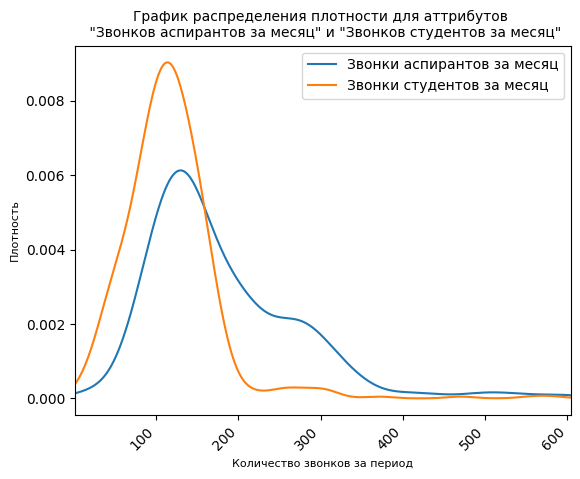

In [ ]:
# Сформулировать и проверить следующие гипотезы
#   студенты звонят чаще аспирантов ко количеству звонков;
# Последовательность проверки:
#   Важно понять с какими данными мы работаем: выделяем исследуемые выборки;
#   Рассчитать точечные оценки (выборочное среднее, медиана, мода) и нарисовать графики плотности (если возможно);
#   Проверяем гипотезу о нормальности каждой из выборок.
#   Если обе выборки имеют нормальное распределение, то для проверки гипотезы о значимости их параметров необходимо применять критерий Стьюдента. В противном случае, т.е. хотя бы одна выборке не подчиняется нормальному закону, используем критерий Манна-Уитни.

# Выделим сборку
print(df.Social.unique())
# Уникальных значений социальнйо категории 4, проще выделить нужные значения в отдельный датафрейм
df2 = pd.DataFrame()
df2['AsCallInMon'] = df[df.Social == 'аспирант']['CallInMon'].reset_index(drop= True )
df2['StCallInMon'] = df[df.Social == 'студент']['CallInMon'].reset_index(drop= True )
# Найдем основные функции
print( df2.agg(['min', pd.DataFrame.mean, pd.DataFrame.median, 'max' ]) )
print( df2.mode() )

ax = df2.plot(kind = 'density')
plt.title('График распределения плотности для аттрибутов \n "Звонков аспирантов за месяц" и "Звонков студентов за месяц"', fontsize = 10)
plt.xlabel('Количество звонков за период', fontsize = 8)
plt.ylabel('Плотность', fontsize = 8)
plt.xticks(rotation = 45,  ha= 'right')
plt.xlim(1,604)
plt.legend(['Звонки аспирантов за месяц', 'Звонки студентов за месяц'])

In [ ]:
# среднее и медиана у аспирантов больше чем у аспирантов
# H0 - имеет нормальное распределение
# H1 - не имеет нормальное распределение
# Проверяем на нормальность с помощью критерия Шапиро
print('''
Проверка на нормальность Шапиро для "Звонки аспирантов за месяц"\n
{}'''.format(shapiro(df2['AsCallInMon'].dropna())))
print(' pvalue < 0.05 - Распределение не соответствует нормальности')
print('''
Проверка на нормальность Шапиро для "Звонки студентов за месяц"\n
{}'''.format(shapiro(df2['StCallInMon'].dropna())))
print(' pvalue < 0.05 - Распределение не соответствует нормальности')

# Проверяем на нормальность с помощью критерия Колмогорова-Смирнова
print('''
Проверка на нормальность Колмогорова-Смирнова для "Звонков аспирантов за месяц"\n
{}'''.format( kstest(df2['StCallInMon'].dropna(), 'norm', args=(df2['StCallInMon'].dropna().mean(), df2['StCallInMon'].dropna().std())) ))
print(' pvalue < 0.05 - Распределение не соответствует нормальности')
print('''
Проверка на нормальность Колмогорова-Смирнова для "Звонков студентов за месяц"\n
{}'''.format( kstest(df2['StCallInMon'].dropna(), 'norm', args=(df2['StCallInMon'].dropna().mean(), df2['StCallInMon'].dropna().std())) ))
print(' pvalue < 0.05 - Распределение не соответствует нормальности')


# H0 : звонки студентов и аспирантов статистически не отличаются
# H1 : звонки студентов < аспирантов , исходя из средних значений.
print('''
Тест Манна-Уитни\n
{}'''.format(mannwhitneyu(df2['StCallInMon'], df2['AsCallInMon'], alternative = 'less', nan_policy = 'omit')))
print(' pvalue < 0.05 - верна гипотеза H1: аспиранты звонят чаще')
# Выводы в конце работы



Проверка на нормальность Шапиро для "Звонки аспирантов за месяц"
 
ShapiroResult(statistic=0.8853591084480286, pvalue=3.840669896833912e-24)
 pvalue < 0.05 - Распределение не соответствует нормальности

Проверка на нормальность Шапиро для "Звонки студентов за месяц"
 
ShapiroResult(statistic=0.806209921836853, pvalue=2.802464258968832e-24)
 pvalue < 0.05 - Распределение не соответствует нормальности

Проверка на нормальность Колмогорова-Смирнова для "Звонков аспирантов за месяц"
 
KstestResult(statistic=0.11576772377526601, pvalue=2.011880635597594e-06, statistic_location=161.0, statistic_sign=1)
 pvalue < 0.05 - Распределение не соответствует нормальности

Проверка на нормальность Колмогорова-Смирнова для "Звонков студентов за месяц"
 
KstestResult(statistic=0.11576772377526601, pvalue=2.011880635597594e-06, statistic_location=161.0, statistic_sign=1)
 pvalue < 0.05 - Распределение не соответствует нормальности

Тест Манна-Уитни
 
MannwhitneyuResult(statistic=109390.5, pvalue=6.01810

[2021 2015 2016 2017 2019 2018 2020]
             Yin19       Yin21
min       4.000000    4.000000
mean    141.969595  135.763514
median  128.000000  128.000000
max     594.000000  601.000000
   Yin19  Yin21
0  108.0   93.0
1  112.0  112.0
2    NaN  126.0
3    NaN  133.0


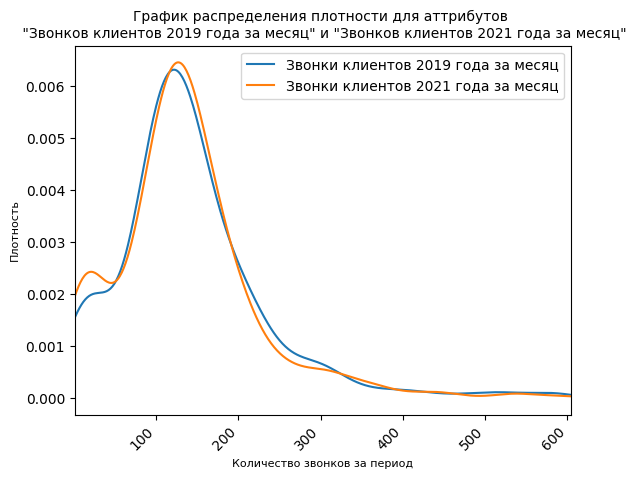

In [ ]:
# Сформулировать и проверить следующие гипотезы
#   клиенты больше звонили в 2019 году по сравнению с 2021 годом по количеству звонков;
# Последовательность проверки:
#   Важно понять с какими данными мы работаем: выделяем исследуемые выборки;
#   Рассчитать точечные оценки (выборочное среднее, медиана, мода) и нарисовать графики плотности (если возможно);
#   Проверяем гипотезу о нормальности каждой из выборок.
#   Если обе выборки имеют нормальное распределение, то для проверки гипотезы о значимости их параметров необходимо применять критерий Стьюдента. В противном случае, т.е. хотя бы одна выборке не подчиняется нормальному закону, используем критерий Манна-Уитни.

# Выделим сборку
print(df.YearIn.unique())
# Уникальных значений года заключения договора 7, проще выделить нужные значения в отдельный датафрейм
df3 = pd.DataFrame()
df3['Yin19'] = df[df.YearIn == 2019]['CallInMon'].reset_index(drop= True )
df3['Yin21'] = df[df.YearIn == 2021]['CallInMon'].reset_index(drop= True )
# Найдем основные функции
print( df3.agg(['min', pd.DataFrame.mean, pd.DataFrame.median, 'max' ]) )
print( df3.mode() )

ax = df3.plot(kind = 'density')
plt.title('График распределения плотности для аттрибутов \n "Звонков клиентов 2019 года за месяц" и "Звонков клиентов 2021 года за месяц"', fontsize = 10)
plt.xlabel('Количество звонков за период', fontsize = 8)
plt.ylabel('Плотность', fontsize = 8)
plt.xticks(rotation = 45,  ha= 'right')
plt.xlim(1,604)
plt.legend(['Звонки клиентов 2019 года за месяц', 'Звонки клиентов 2021 года за месяц'])


In [ ]:
# среднее и медиана у аспирантов больше чем у аспирантов
# H0 - имеет нормальное распределение
# H1 - не имеет нормальное распределение
# Проверяем на нормальность с помощью критерия Шапиро
print('''
Проверка на нормальность Шапиро для "Звонки клиентов 2019 года за месяц"\n
{}'''.format(shapiro(df3['Yin19'].dropna())))
print(' pvalue < 0.05 - Распределение не соответствует нормальности')
print('''
Проверка на нормальность Шапиро для "Звонки клиентов 2021 года за месяц"\n
{}'''.format(shapiro(df3['Yin21'].dropna())))
print(' pvalue < 0.05 - Распределение не соответствует нормальности')

# Проверяем на нормальность с помощью критерия Колмогорова-Смирнова
print('''
Проверка на нормальность Колмогорова-Смирнова для "Звонков клиентов 2019 года за месяц"\n
{}'''.format( kstest(df3['Yin19'].dropna(), 'norm', args=(df3['Yin19'].dropna().mean(), df3['Yin19'].dropna().std())) ))
print(' pvalue < 0.05 - Распределение не соответствует нормальности')
print('''
Проверка на нормальность Колмогорова-Смирнова для "Звонков клиентов 2021 года за месяц"\n
{}'''.format( kstest(df3['Yin21'].dropna(), 'norm', args=(df3['Yin21'].dropna().mean(), df3['Yin21'].dropna().std())) ))
print(' pvalue < 0.05 - Распределение не соответствует нормальности')


# H0 : звонки Звонков клиентов 2019 и Звонков клиентов 2021 статистически не отличаются
# H1 : звонки Звонков клиентов 2019 < Звонков клиентов 2021 , исходя из средних значений.
print('''
Тест Манна-Уитни\n
{}'''.format(mannwhitneyu(df3['Yin19'], df3['Yin21'], alternative = 'greater', nan_policy = 'omit')))
print(' pvalue > 0.05 - верна гипотеза H0: Звонки клиентов 2019 и Звонки клиентов 2021 статистически не отличаются')
# Выводы в конце работы


Проверка на нормальность Шапиро для "Звонки клиентов 2019 года за месяц"
 
ShapiroResult(statistic=0.8737098574638367, pvalue=1.7021864412887203e-21)
 pvalue < 0.05 - Распределение не соответствует нормальности

Проверка на нормальность Шапиро для "Звонки клиентов 2021 года за месяц"
 
ShapiroResult(statistic=0.8880188465118408, pvalue=2.637079096241615e-20)
 pvalue < 0.05 - Распределение не соответствует нормальности

Проверка на нормальность Колмогорова-Смирнова для "Звонков клиентов 2019 года за месяц"
 
KstestResult(statistic=0.1387062795756817, pvalue=2.1313066774156297e-10, statistic_location=158.0, statistic_sign=1)
 pvalue < 0.05 - Распределение не соответствует нормальности

Проверка на нормальность Колмогорова-Смирнова для "Звонков клиентов 2021 года за месяц"
 
KstestResult(statistic=0.1179647019343738, pvalue=1.2349315591359048e-07, statistic_location=177.0, statistic_sign=1)
 pvalue < 0.05 - Распределение не соответствует нормальности

Тест Манна-Уитни
 
MannwhitneyuResul

             Stu19       Stu21
min      23.000000   17.000000
mean    123.441176  110.516129
median  108.000000  110.500000
max     470.000000  314.000000
   Stu19  Stu21
0  108.0   51.0
1  135.0    NaN


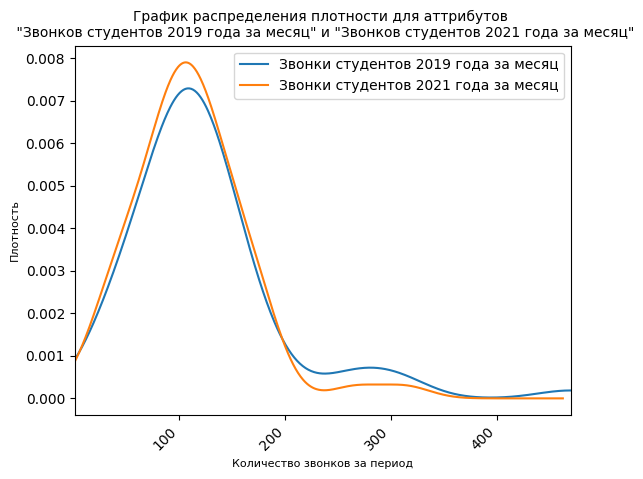

In [ ]:
# Сформулировать и проверить следующие гипотезы
#   студенты больше совершили звонков в 2019 году по сравнению с 2021 годом.
# Последовательность проверки:
#   Важно понять с какими данными мы работаем: выделяем исследуемые выборки;
#   Рассчитать точечные оценки (выборочное среднее, медиана, мода) и нарисовать графики плотности (если возможно);
#   Проверяем гипотезу о нормальности каждой из выборок.
#   Если обе выборки имеют нормальное распределение, то для проверки гипотезы о значимости их параметров необходимо применять критерий Стьюдента. В противном случае, т.е. хотя бы одна выборке не подчиняется нормальному закону, используем критерий Манна-Уитни.

# Выделим сборку, проще выделить нужные значения в отдельный датафрейм
df4 = pd.DataFrame()
df4['Stu19'] = df[(df.YearIn == 2019) & (df.Social == 'студент')]['CallInMon'].reset_index(drop= True )
df4['Stu21'] = df[(df.YearIn == 2021) & (df.Social == 'студент')]['CallInMon'].reset_index(drop= True )
# Найдем основные функции
print( df4.agg(['min', pd.DataFrame.mean, pd.DataFrame.median, 'max' ]) )
print( df4.mode() )

ax = df4.plot(kind = 'density')
plt.title('График распределения плотности для аттрибутов \n "Звонков студентов 2019 года за месяц" и "Звонков студентов 2021 года за месяц"', fontsize = 10)
plt.xlabel('Количество звонков за период', fontsize = 8)
plt.ylabel('Плотность', fontsize = 8)
plt.xticks(rotation = 45,  ha= 'right')
plt.xlim(1,470)
plt.legend(['Звонки студентов 2019 года за месяц', 'Звонки студентов 2021 года за месяц'])

In [ ]:
# среднее и медиана у аспирантов больше чем у аспирантов
# H0 - имеет нормальное распределение
# H1 - не имеет нормальное распределение
# Проверяем на нормальность с помощью критерия Шапиро
print('''
Проверка на нормальность Шапиро для "Звонки студентов 2019 года за месяц"\n
{}'''.format(shapiro(df4['Stu19'].dropna())))
print(' pvalue < 0.05 - Распределение не соответствует нормальности')
print('''
Проверка на нормальность Шапиро для "Звонки студентов 2021 года за месяц"\n
{}'''.format(shapiro(df4['Stu21'].dropna())))
print(' pvalue < 0.05 - Распределение не соответствует нормальности')

# Проверяем на нормальность с помощью критерия Колмогорова-Смирнова
print('''
Проверка на нормальность Колмогорова-Смирнова для "Звонков студентов 2019 года за месяц"\n
{}'''.format( kstest(df4['Stu19'].dropna(), 'norm', args=(df4['Stu19'].dropna().mean(), df4['Stu19'].dropna().std())) ))
print(' pvalue < 0.05 - Распределение не соответствует нормальности')
print('''
Проверка на нормальность Колмогорова-Смирнова для "Звонков студентов 2021 года за месяц"\n
{}'''.format( kstest(df4['Stu21'].dropna(), 'norm', args=(df4['Stu21'].mean(), df4['Stu21'].dropna().std())) ))
print(' pvalue < 0.05 - Распределение не соответствует нормальности')


# H0 : звонки студентов 2019 и звонки студентов 2021 статистически не отличаются
# H1 : звонки студентов 2019 > звонки студентов 2021 , исходя из средних значений.
print('''
Тест Манна-Уитни\n
{}'''.format(mannwhitneyu(df4['Stu19'], df4['Stu21'], alternative = 'greater', nan_policy = 'omit')))
print(' pvalue > 0.05 - верна гипотеза H0: звонки студентов 2019 и звонки студентов 2021 статистически не отличаются')
# Выводы в конце работы


Проверка на нормальность Шапиро для "Звонки студентов 2019 года за месяц"
 
ShapiroResult(statistic=0.8067211508750916, pvalue=5.047246887102119e-08)
 pvalue < 0.05 - Распределение не соответствует нормальности

Проверка на нормальность Шапиро для "Звонки студентов 2021 года за месяц"
 
ShapiroResult(statistic=0.9302850961685181, pvalue=0.0016740118153393269)
 pvalue < 0.05 - Распределение не соответствует нормальности

Проверка на нормальность Колмогорова-Смирнова для "Звонков студентов 2019 года за месяц"
 
KstestResult(statistic=0.185985049394223, pvalue=0.01564740345754878, statistic_location=138.0, statistic_sign=1)
 pvalue < 0.05 - Распределение не соответствует нормальности

Проверка на нормальность Колмогорова-Смирнова для "Звонков студентов 2021 года за месяц"
 
KstestResult(statistic=0.10071868881659563, pvalue=0.5227125212899479, statistic_location=123.0, statistic_sign=1)
 pvalue < 0.05 - Распределение не соответствует нормальности

Тест Манна-Уитни
 
MannwhitneyuResult(st

Сформулировать и проверить следующие гипотезы:
1.  клиенты чаще звонят днем или вечером по количеству звонков;
2.  клиенты чаще звонят днем или (вечером + ночью) по количеству звонков;
3.  студенты звонят чаще аспирантов ко количеству звонков;
4.  клиенты больше звонили в 2019 году по сравнению с 2021 годом по количеству звонков;
5.  студенты больше совершили звонков в 2019 году по сравнению с 2021 годом.

Результаты:
1.  **Клиенты чаще звонят вечером**
2.  **Клиенты чаще звонят вечером + ночью**
3.  **Аспиранты звонят чаще студентов**
4.  **Звонки клиентов 2019 и Звонки клиентов 2021 статистически не отличаются**
5.  **звонки студентов 2019 и звонки студентов 2021 статистически не отличаются**